<a href="https://colab.research.google.com/github/Mutum/Mutum-computer_vision_EVA/blob/main/Session%204%20-%20Coding%20Drill%20Down%20/EVA8_S4_step3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Target
- Introduce StepLR rate scheduler with a higher learning rate of 0.02 .
- Remember we need to learn more as there were larger gap between train and test metrics
### Results
- Parameters: 7,432
- Best Train Accuracy 97.80
- Best test accuracy 99.40%
## Analysis
Model with 7.4K parameters is cross 99.40% accuracy in 10 epochs.
its only one time hit of 99.4 , needs to stabilized though

In [ ]:

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.RandomAffine(degrees=7, shear=10, translate=(0.1, 0.1), scale=(0.8, 1.2)),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [ ]:
train = datasets.MNIST('./data', train=True, download = True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

## Dataloader Arguments & Test/Train Dataloaders

In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Availalbe?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments
dataloader_args = dict(shuffle=True,batch_size=128,num_workers=4,pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Availalbe? True


## Model

In [ ]:
dropout_value = 0.1


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            # nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            # nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),

        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


## Model Params

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 16, 24, 24]           1,152
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
           Dropout-7           [-1, 16, 24, 24]               0
            Conv2d-8            [-1, 8, 24, 24]             128
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10           [-1, 16, 10, 10]           1,152
             ReLU-11           [-1, 16, 10, 10]               0
      BatchNorm2d-12           [-1, 16, 10, 10]              32

## Training and Testing

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)

optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.01)



EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.17355139553546906 Batch_id=468 Accuracy=83.40: 100%|██████████| 469/469 [00:46<00:00, 10.04it/s]



Test set: Average loss: 0.0937, Accuracy: 9720/10000 (97.20%)

EPOCH: 1


Loss=0.1817193478345871 Batch_id=468 Accuracy=95.25: 100%|██████████| 469/469 [00:47<00:00,  9.85it/s]



Test set: Average loss: 0.0467, Accuracy: 9852/10000 (98.52%)

EPOCH: 2


Loss=0.17374473810195923 Batch_id=468 Accuracy=95.99: 100%|██████████| 469/469 [00:46<00:00, 10.01it/s]



Test set: Average loss: 0.0410, Accuracy: 9873/10000 (98.73%)

EPOCH: 3


Loss=0.09134160727262497 Batch_id=468 Accuracy=96.56: 100%|██████████| 469/469 [00:47<00:00,  9.90it/s]



Test set: Average loss: 0.0357, Accuracy: 9880/10000 (98.80%)

EPOCH: 4


Loss=0.06061002239584923 Batch_id=468 Accuracy=96.95: 100%|██████████| 469/469 [00:47<00:00,  9.98it/s]



Test set: Average loss: 0.0362, Accuracy: 9886/10000 (98.86%)

EPOCH: 5


Loss=0.03231848403811455 Batch_id=468 Accuracy=96.99: 100%|██████████| 469/469 [00:47<00:00,  9.94it/s]



Test set: Average loss: 0.0328, Accuracy: 9900/10000 (99.00%)

EPOCH: 6


Loss=0.09551512449979782 Batch_id=468 Accuracy=97.21: 100%|██████████| 469/469 [00:47<00:00,  9.91it/s]



Test set: Average loss: 0.0248, Accuracy: 9923/10000 (99.23%)

EPOCH: 7


Loss=0.033122871071100235 Batch_id=468 Accuracy=97.44: 100%|██████████| 469/469 [00:47<00:00,  9.89it/s]



Test set: Average loss: 0.0279, Accuracy: 9912/10000 (99.12%)

EPOCH: 8


Loss=0.10166377574205399 Batch_id=468 Accuracy=97.38: 100%|██████████| 469/469 [00:47<00:00,  9.83it/s]



Test set: Average loss: 0.0265, Accuracy: 9918/10000 (99.18%)

EPOCH: 9


Loss=0.2353072315454483 Batch_id=468 Accuracy=97.58: 100%|██████████| 469/469 [00:47<00:00,  9.94it/s]



Test set: Average loss: 0.0272, Accuracy: 9905/10000 (99.05%)

EPOCH: 10


Loss=0.16309036314487457 Batch_id=468 Accuracy=97.55: 100%|██████████| 469/469 [00:47<00:00,  9.93it/s]



Test set: Average loss: 0.0202, Accuracy: 9940/10000 (99.40%)

EPOCH: 11


Loss=0.15460635721683502 Batch_id=468 Accuracy=97.63: 100%|██████████| 469/469 [00:47<00:00,  9.94it/s]



Test set: Average loss: 0.0238, Accuracy: 9916/10000 (99.16%)

EPOCH: 12


Loss=0.07417529821395874 Batch_id=468 Accuracy=97.64: 100%|██████████| 469/469 [00:46<00:00, 10.16it/s]



Test set: Average loss: 0.0215, Accuracy: 9936/10000 (99.36%)

EPOCH: 13


Loss=0.07239142805337906 Batch_id=468 Accuracy=97.80: 100%|██████████| 469/469 [00:46<00:00, 10.06it/s]



Test set: Average loss: 0.0225, Accuracy: 9928/10000 (99.28%)

EPOCH: 14


Loss=0.04090246930718422 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:46<00:00, 10.07it/s]



Test set: Average loss: 0.0211, Accuracy: 9932/10000 (99.32%)



Text(0.5, 1.0, 'Test Accuracy')

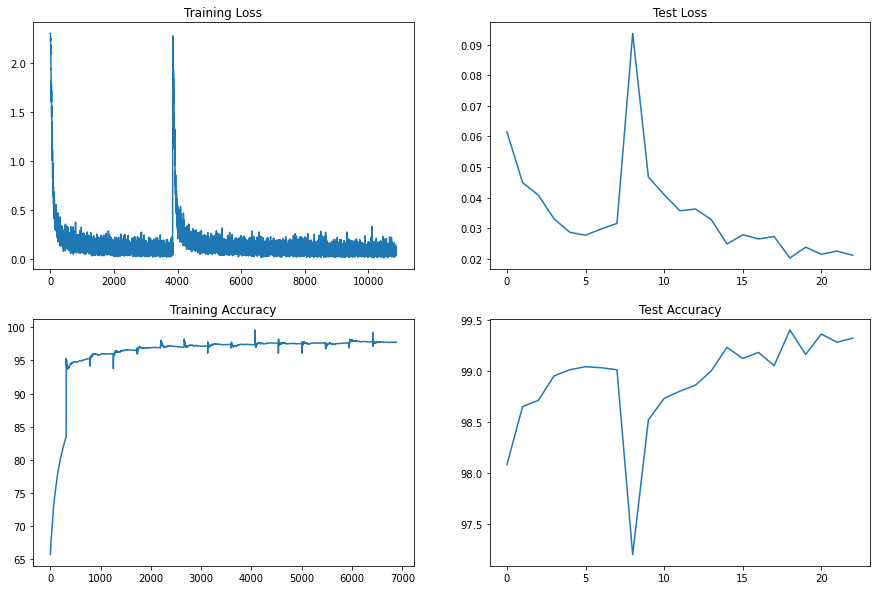

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")